## Import

In [16]:
import os
import numpy as np
import cv2
from os.path import join
from glob import glob
import matplotlib.pyplot as plt
import skimage
import time
import math
import random
from tqdm.notebook import tqdm
from skimage.morphology import skeletonize

In [17]:
img1 = cv2.imread('./data/001_00.png', 0)
img2 = cv2.imread('./data/002_00.png', 0)

## Preprocessing

  0%|          | 0/254 [00:00<?, ?it/s]

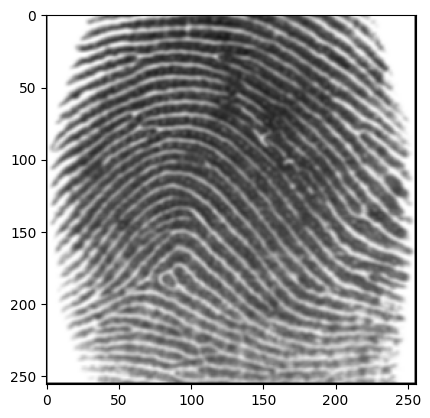

In [18]:
# 이미지의 색상을 보정하기 위해 블러처리
def blur_image(image_props, ks):
    kernel = np.ones((ks, ks)) / (ks*ks) # 평균내는 커널

    rows, cols = image_props.shape[:2]
    filtered_img = np.zeros(image_props.shape, dtype=np.uint8)

    for i in tqdm(range(ks//2,rows-ks//2)):
            for j in range(ks//2,cols-ks//2):
                result = 0
                for k_i in range(0, len(kernel)):
                    for k_j in range(0, len(kernel[0])):
                        result += image_props[i-ks//2+k_i, j-ks//2+k_j] * kernel[(len(kernel)-1)-k_i, (len(kernel)-1)-k_j]  # convolution
                filtered_img[i, j] = int(result)
    plt.imshow(cv2.cvtColor(filtered_img, cv2.COLOR_GRAY2RGB))
    return filtered_img

blured_image = blur_image(img1, 3)

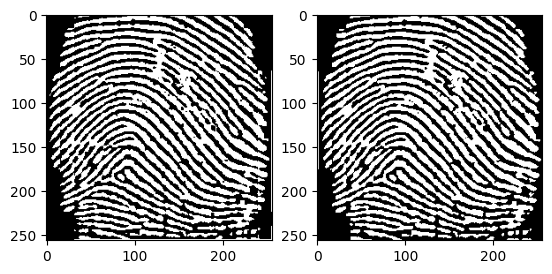

In [19]:
# 블럭 단위로 threshold를 정해서 이미지를 이진화하는 함수
def binarize_image(image_props, block_size=16):
    # 이미지 크기
    height, width = image_props.shape[:2]

    # 블록 단위로 이미지를 분할하고 각 블록에 대해 thresholding 적용
    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            # 현재 블록 좌표
            block_top = y
            block_bottom = min(y + block_size, height)
            block_left = x
            block_right = min(x + block_size, width)

            # 블록 영역 추출
            block = image_props[block_top:block_bottom, block_left:block_right]

            # 블록 내 픽셀 평균 계산
            block_mean = np.mean(block)

            # 블록 내 픽셀 평균을 기준으로 thresholding
            _, block_threshold = cv2.threshold(block, block_mean, 255, cv2.THRESH_BINARY)

            # 배경 픽셀 비율 계산
            background_pixels = np.count_nonzero(block_threshold == 0)
            total_pixels = block_threshold.size
            background_ratio = background_pixels / total_pixels

            # 배경이 90프로 이상인 흰색인 경우 배경으로 간주
            if background_ratio >= 0.9 or block_mean > 220:
                block_threshold = np.ones_like(block_threshold) * 255

            # 이진화 결과를 원본 이미지에 복사
            image_props[block_top:block_bottom, block_left:block_right] = block_threshold

    return image_props

# 이미지 이진화 수행
binarized_image = binarize_image(blured_image)

# 색상 반전
binarized_image = cv2.bitwise_not(binarized_image)

# 이진화 후 결과 이미지 출력
plt.subplot(1,2,1)
plt.imshow(binarized_image, cmap='gray')

# 모폴로지 연산
k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
binarized_image = cv2.morphologyEx(binarized_image, cv2.MORPH_OPEN, k, iterations=1)

# 모폴로지 후 결과 이미지 출력
plt.subplot(1,2,2)
plt.imshow(binarized_image, cmap='gray')



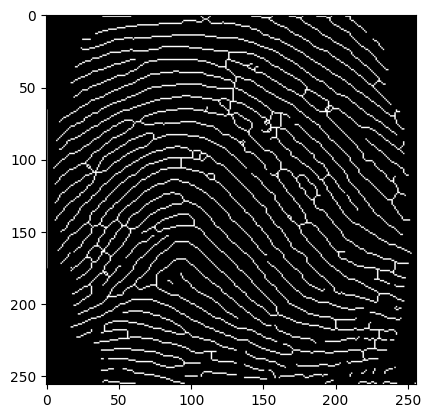

In [20]:
# 세선화
img_skeleton = skeletonize(binarized_image.astype(np.float32) / 255)
plt.imshow(img_skeleton, cmap='gray')

## Feature extraction

In [21]:
# Ending point와 Bifurcation point를 찾는 함수
def find_minutiae_points(image_props, fig_show):
    image_props = image_props.astype(np.uint8)
    ending_points = []
    bifurcation_points = []
    height, width = image_props.shape[:2]

    for y in range(1, height-1):
        for x in range(1, width-1):
            window = image_props[y - 1:y + 2, x - 1:x + 2]
            is_center_white = (image_props[y,x]==1)

            # 3x3 윈도우 내에서 픽셀이 흰색인 픽셀의 개수를 계산
            pixel_count = np.sum(window == 1)

            # Ending point는 2개의 화이트 픽셀을 가지는 경우로 판단
            if is_center_white and pixel_count == 2:
                ending_points.append((x, y))

            # Bifurcation point는 4개의 화이트 픽셀을 가지는 경우로 판단
            if is_center_white and pixel_count == 4:
                bifurcation_points.append((x, y))

    if fig_show:
        # 이미지를 복사하여 표시할 이미지 생성
        image_with_points = np.copy(image_props)
        image_with_points = image_with_points.astype(np.uint8) * 255

        # 결과 이미지를 RGB로 변환
        image_with_points = cv2.cvtColor(image_with_points, cv2.COLOR_GRAY2BGR)

        # Ending Point를 파란색으로 표시
        for ending in ending_points:
            x, y = ending
            cv2.circle(image_with_points, (x,y), 1, (0, 0, 255), -1)

        # Bifurcation Point를 빨간색으로 표시
        for bifurcation in bifurcation_points:
            x, y = bifurcation
            cv2.circle(image_with_points, (x,y), 1, (255, 0, 0), -1)
        
        return image_with_points
    
    else:
        return ending_points, bifurcation_points

# Ending point와 Bifurcation point 찾기
# endings, bifurcations = find_minutiae_points(img_skeleton, fig_show=True)



## sum

  0%|          | 0/254 [00:00<?, ?it/s]

/var/folders/cj/qygyr1hs6y78_byt1kgcz9bm0000gn/T/ipykernel_94403/4020120321.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,1)


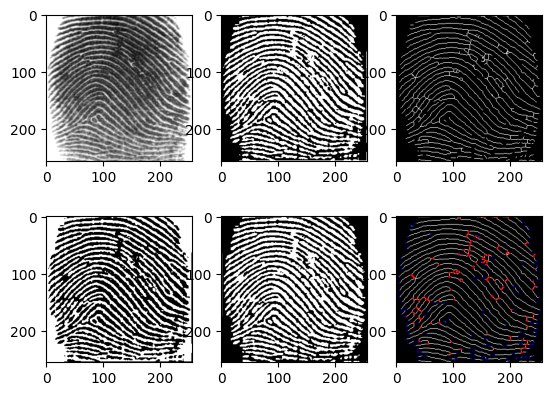

In [22]:
# 이미지를 넣으면 feature points들을 return 하는 함수
def get_fp_feature(img_test, fig_show):
  # 이미지 블러
  blured_img = blur_image(img_test, 3)
  # 이미지 이진화
  binarized_img = binarize_image(blured_img)
  # 색상 반전
  binarized_img = cv2.bitwise_not(binarized_img)
  # 모폴로지 연산
  k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
  mop_img = cv2.morphologyEx(binarized_img, cv2.MORPH_OPEN, k, iterations=1)
  # 세선화
  skeleton_img = skeletonize(mop_img.astype(np.float32) / 255)
  # 스켈레톤 위 포인트 가시화
  points_img = find_minutiae_points(skeleton_img,fig_show=True)

  if fig_show:
    plt.subplot(2,3,1)
    plt.imshow(img_test, cmap='gray')
    plt.subplot(2,3,4)
    plt.imshow(blured_img, cmap='gray')
    plt.subplot(2,3,2)
    plt.imshow(binarized_img, cmap='gray')
    plt.subplot(2,3,5)
    plt.imshow(mop_img, cmap='gray')
    plt.subplot(2,3,3)
    plt.imshow(skeleton_img, cmap='gray')
    plt.subplot(2,3,6)
    plt.imshow(points_img)

  # Ending point와 Bifurcation point 찾기
  endings, bifurcations = find_minutiae_points(skeleton_img, fig_show=False)

  return endings, bifurcations

q_end, q_bif = get_fp_feature(img1, fig_show=True)

## Matching

In [23]:
train_path = './train_ref'
test2_path = './test2'

list_train = sorted(glob(join(train_path, '*.BMP')))
list_test2 = sorted(glob(join(test2_path, '*.BMP')))
print(len(list_train), len(list_test2))

477 1428


./test2/100_type1.BMP 100 ./train_ref/100.BMP


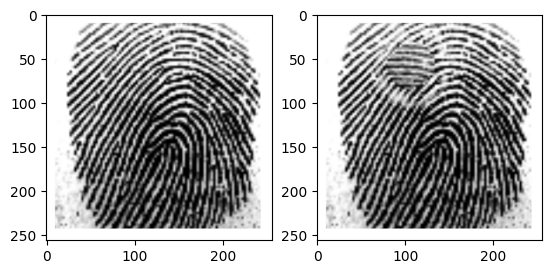

In [24]:
target_path = list_test2[0]
basename = os.path.basename(target_path).split('_')[0]
train_sample_path = join(train_path, basename + '.BMP')
print(target_path, basename, train_sample_path)
img_train = cv2.imread(train_sample_path)
img_test = cv2.imread(target_path)

plt.subplot(1,2,1)
plt.imshow(img_train, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_test, cmap='gray')

In [25]:
# train, test를 그레이스케일로 변환
img_test = cv2.cvtColor(img_test, cv2.COLOR_RGB2GRAY)
img_train = cv2.cvtColor(img_train, cv2.COLOR_RGB2GRAY)

  0%|          | 0/254 [00:00<?, ?it/s]

/var/folders/cj/qygyr1hs6y78_byt1kgcz9bm0000gn/T/ipykernel_94403/4020120321.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,1)


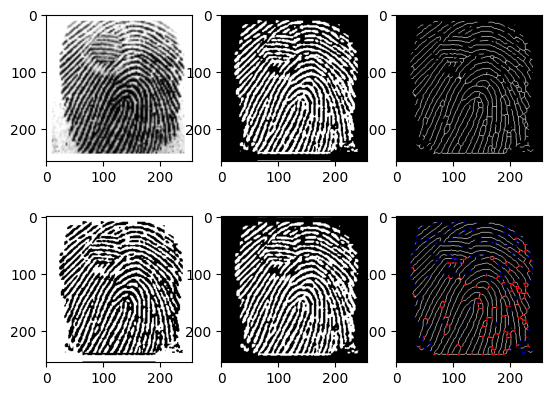

In [26]:
q_end, q_bif = get_fp_feature(img_test, fig_show=True)

  0%|          | 0/254 [00:00<?, ?it/s]

/var/folders/cj/qygyr1hs6y78_byt1kgcz9bm0000gn/T/ipykernel_94403/4020120321.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,1)


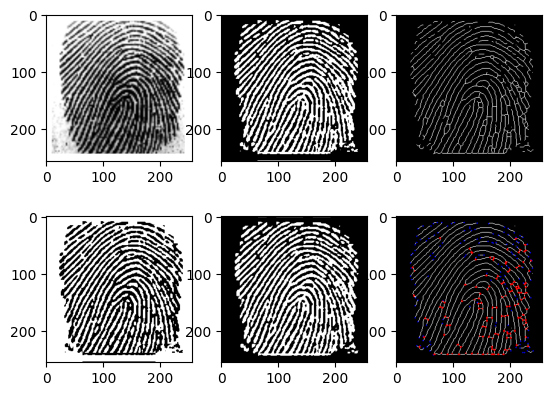

In [27]:
db_end, db_bif = get_fp_feature(img_train, fig_show=True)

In [28]:
feat_query = np.concatenate([q_end, q_bif]).astype(np.uint8) # test 특징점
feat_train = np.concatenate([db_end, db_bif]).astype(np.uint8) # train 특징점

In [29]:
print(len(feat_query), len(feat_train))

566 520


/var/folders/cj/qygyr1hs6y78_byt1kgcz9bm0000gn/T/ipykernel_94403/2600184509.py:24: RuntimeWarning: overflow encountered in scalar subtract
  if min_distance < threshold and abs(query_point[1] - train_y)< 4:


거리의 합: 1.0
매칭 point 개수: 220


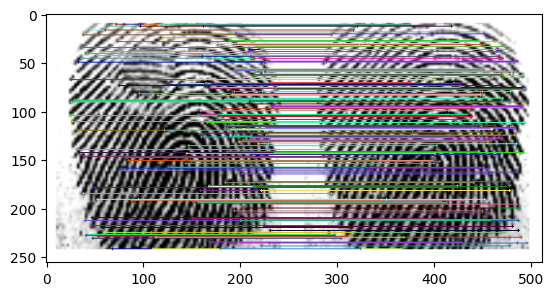

In [30]:
def calculate_euclidean_distance(point1, point2):
    distance = np.sqrt(np.sum((point1 - point2)**2))
    return distance

def match_finger(feat_query, feat_train, threshold, fig_show, img_query, img_train):
    dist_sum = 0
    len_match = 0

    if fig_show:
        img_query = cv2.cvtColor(img_query, cv2.COLOR_GRAY2BGR)
        img_train = cv2.cvtColor(img_train, cv2.COLOR_GRAY2BGR)
        fig_concat = cv2.hconcat([img_query, img_train])

    for query_point in feat_query:
        min_distance = float('inf')

        train_x, train_y = 0 ,0
        for train_point in feat_train:
            distance = calculate_euclidean_distance(query_point, train_point)
            if distance < min_distance:
                min_distance = distance
                train_x, train_y = train_point[0], train_point[1]

        if min_distance < threshold and abs(query_point[1] - train_y)< 4: 
            dist_sum += min_distance
            len_match += 1
            
            if fig_show:
                # 랜덤한 색상 생성
                color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
                cv2.circle(fig_concat, (query_point[0],query_point[1]), 1, color, -1)
                cv2.circle(fig_concat, (train_x+256, train_y), 1, color, -1)
                cv2.line(fig_concat, (query_point[0],query_point[1]), (train_x+256, train_y), color, 1)

    if fig_show:
        plt.imshow(fig_concat)

    return dist_sum, len_match

dist, len_match = match_finger(feat_query, feat_train, 2, True, img_test, img_train)
print('거리의 합:',dist)
print('매칭 point 개수:',len_match)


  0%|          | 0/254 [00:00<?, ?it/s]

/var/folders/cj/qygyr1hs6y78_byt1kgcz9bm0000gn/T/ipykernel_94403/4020120321.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,1)


>>> 662


/var/folders/cj/qygyr1hs6y78_byt1kgcz9bm0000gn/T/ipykernel_94403/2600184509.py:24: RuntimeWarning: overflow encountered in scalar subtract
  if min_distance < threshold and abs(query_point[1] - train_y)< 4:


거리의 합: 4.414213562373095
매칭 point 개수: 33


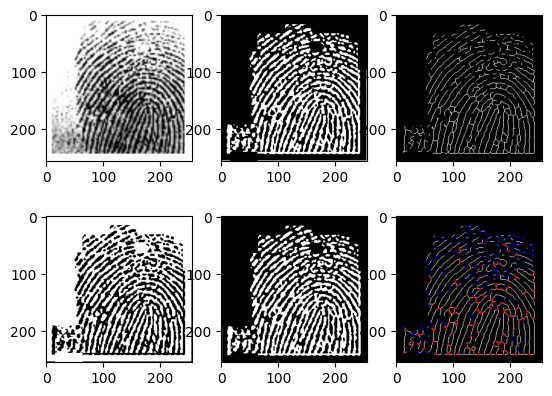

In [31]:
img_train2 = cv2.cvtColor(cv2.imread(list_train[1]), cv2.COLOR_RGB2GRAY)
db_x_end, db_x_bif = get_fp_feature(img_train2, True) # train2 이미지의 fp point
feat_db_x = np.concatenate([db_x_end, db_x_bif]).astype(np.uint8)
print('>>>',len(feat_db_x))
dist, len_match = match_finger(feat_query, feat_db_x, 2, False, img_query=img_test, img_train=img_train2)

print('거리의 합:',dist)
print('매칭 point 개수:',len_match)

/var/folders/cj/qygyr1hs6y78_byt1kgcz9bm0000gn/T/ipykernel_94403/2600184509.py:24: RuntimeWarning: overflow encountered in scalar subtract
  if min_distance < threshold and abs(query_point[1] - train_y)< 4:


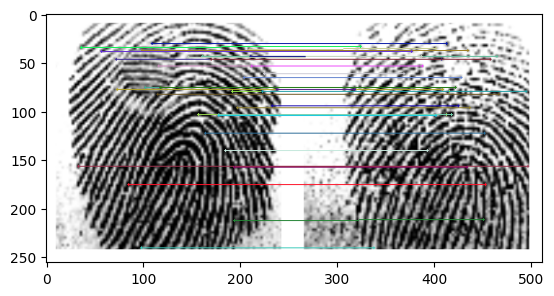

In [32]:
dist, len_match = match_finger(feat_query, feat_db_x, 2, True, img_query=img_test, img_train=img_train2)

In [ ]:
dict_result = {}
for t in list_train:
    basename = os.path.basename(t)
    img_train = cv2.cvtColor(cv2.imread(t), cv2.COLOR_RGB2GRAY)
    db_x_end, db_x_bif = get_fp_feature(img_train, False)
    feat_db_x = np.concatenate([db_x_end, db_x_bif]).astype(np.uint8)
    dist, len_match = match_finger(feat_query, feat_db_x, 2, False, img_query=img_test, img_train=img_train)
    dict_result[basename] = [dist, len_match, len(feat_query), len(feat_db_x)]

In [35]:
dict_result

{'1.BMP': [4.0, 43, 566, 662],
 '10.BMP': [4.414213562373095, 33, 566, 662],
 '100.BMP': [1.0, 220, 566, 520],
 '101.BMP': [8.82842712474619, 48, 566, 521],
 '102.BMP': [14.0, 50, 566, 490],
 '104.BMP': [5.0, 52, 566, 553],
 '105.BMP': [6.414213562373095, 35, 566, 520],
 '106.BMP': [6.0, 37, 566, 535],
 '107.BMP': [5.82842712474619, 39, 566, 505],
 '108.BMP': [6.414213562373095, 44, 566, 523],
 '11.BMP': [10.414213562373096, 45, 566, 347],
 '111.BMP': [12.828427124746192, 48, 566, 369],
 '112.BMP': [3.0, 44, 566, 977],
 '113.BMP': [4.414213562373095, 40, 566, 718],
 '116.BMP': [12.82842712474619, 35, 566, 324],
 '12.BMP': [6.414213562373095, 46, 566, 454],
 '120.BMP': [3.0, 47, 566, 1017],
 '122.BMP': [1.0, 33, 566, 899],
 '123.BMP': [13.414213562373096, 53, 566, 392],
 '124.BMP': [4.0, 39, 566, 1129],
 '125.BMP': [15.0, 36, 566, 310],
 '128.BMP': [9.414213562373096, 48, 566, 604],
 '129.BMP': [12.0, 52, 566, 405],
 '131.BMP': [1.0, 32, 566, 962],
 '132.BMP': [15.414213562373096, 56, 5